In [45]:
#Load packages
import altair as alt
alt.data_transformers.enable('json')
alt.renderers.enable('notebook')
import pandas as pd
import pickle
import numpy as np
import networkx as nx
import nx_altair as nxa
import EoN
import math
#import matplotlib.pyplot as plt
#import pydot
#from networkx.drawing.nx_pydot import graphviz_layout

#Read in data
df = pd.read_csv("../data/Books.csv",)
df = pd.read_csv("../data/all-nodes.csv",)
df = pd.read_csv("../data/PetSupplies.csv")
#with open(r"../data/tree-all.pickle", 'rb') as file:
#    rawdata = file.read()
#books_pickle = pickle.loads(rawdata)

#Function to count the depth of the node
def count_depth (pathName):
   return pathName.count("',")

In [46]:
#This creates the depth column
df['Depth'] = df.pathName.apply(count_depth)
df.head()

,id,name,productCount,subtreeProductCount,parent,numChildren,pathName,children,alsoCount,also,Depth
0,0,Pet Supplies,4113,0,0,34,['Pet Supplies'],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0,[],0
1,1,Dogs,25,72403,0,16,"['Pet Supplies', 'Dogs']","[359, 360, 361, 362, 363, 364, 365, 366, 367, ...",0,[],1
2,2,Pet Supplies: International Shipping Available,957,957,0,0,"['Pet Supplies', 'Pet Supplies: International ...",[],11,"[(391, 6), (448, 3), (252, 2), (343, 2), (407,...",1
3,3,Small Animals,4,3090,0,11,"['Pet Supplies', 'Small Animals']","[335, 336, 337, 338, 339, 340, 341, 342, 343, ...",0,[],1
4,4,Cats,17,12983,0,16,"['Pet Supplies', 'Cats']","[231, 232, 233, 234, 235, 236, 237, 238, 239, ...",0,[],1


In [ ]:
#Add select dropdown for depth
depth_choices = df.Depth.unique().tolist()
depth_choices = sorted(depth_choices)
depth_dropdown = alt.binding_select(options=depth_choices)
depth_select = alt.selection_single(fields=['Depth'], bind=depth_dropdown, name = " ")

#Create altair bar chart
alt.Chart(df).mark_bar().encode(
    y='subtreeProductCount:Q',
    x=alt.X(
        "name:O",
        sort = alt.SortField(
            field = "subtreeProductCount",
            order = "descending"))
    ).add_selection(depth_select
    ).transform_filter(depth_select
    ).properties(width=600)


In [ ]:
#Selection for left chart
brush = alt.selection_interval(encodings=['x'],empty='all')
brush_single = alt.selection_single(encodings=['x'], empty = 'all')

#Product categories by number of products
left = alt.Chart(df[1:]).mark_bar().encode(
        alt.X("productCount:Q",
          bin=alt.BinParams(extent = [0,2500], step = 250),
          scale=alt.Scale(domain=(0, 2500)),
          axis=alt.Axis(title="Number of Products")),
        alt.Y('count()',
          axis=alt.Axis(title = "Number of Nodes"))
    ).properties(width = 400, height = 400)

#Product categories by depth
#right = alt.Chart(df[1:]).mark_bar().encode(
#        alt.X("percent_of_total:Q",
#             scale=alt.Scale(domain=(0,1)),
#             axis=alt.Axis(title = "% of Nodes", format = '.0%')),
#        alt.Y('Depth:O',
#              scale=alt.Scale(domain=(1,2,3,4,5,6)))
#    ).properties(width = 400, height = 400
#    ).transform_filter(brush
#    ).transform_joinaggregate(
#        total_count='count(Depth)'
#    ).transform_joinaggregate(
#        depth_count='count(Depth)',
#        groupby=['Depth']
#    ).transform_calculate(
#        percent_of_total = "datum.depth_count / datum.total_count")

#Product categories by depth
right = alt.Chart(df[1:]).mark_bar().encode(
        alt.Y("count()",
             axis=alt.Axis(title = "")),
        alt.X('Depth:O',
              )
    ).properties(width = 400, height = 400)

                 
# gray background with selection
left_background = left.encode(
    color=alt.value('#ddd')
).add_selection(brush)

# blue highlights on the transformed data
left_highlight = left.transform_filter(brush).transform_filter(brush_single)

left_final = alt.layer(
    left_background,
    left_highlight,
    data=books_df
    )

right_background = right.encode(
    color=alt.value('#ddd')
).add_selection(brush_single)

# blue highlights on the transformed data
right_highlight = right.transform_filter(brush_single).transform_filter(brush)

right_final = alt.layer(
    right_background,
    right_highlight,
    data=books_df
    )

alt.hconcat(left_final,
            right_final, 
            data=df, 
            title = "Distribution of Product Categories by Number of Products & Depth",
            resolve = alt.Resolve(scale=alt.LegendResolveMap(color=alt.ResolveMode('independent')))).display()

In [212]:
#https://stackoverflow.com/questions/29586520/can-one-get-hierarchical-graphs-from-networkx-with-python-3

#Create the graph and convert to tree
G = nx.from_pandas_edgelist(df, source = "parent", target = "id", edge_attr = True)
G = nx.bfs_tree(G, 0)

#Circular position, to convert to top down remove with and use pos below
pos = EoN.hierarchy_pos(G,0)#, width = 2*math.pi)
circle_pos = {u:(r*math.cos(theta),r*math.sin(theta)) for u, (theta, r) in pos.items()}

#Supply attributes to the nodes
for n in G.nodes():
    G.nodes[n]['id'] = df['id'][n]
    G.nodes[n]['name'] = df['name'][n]
    G.nodes[n]['Depth'] = df['Depth'][n]
    G.nodes[n]['productCount'] = df['productCount'][n]
    G.nodes[n]['subtreeProductCount'] = df['subtreeProductCount'][n]
    G.nodes[n]['numChildren'] = df['numChildren'][n]
    G.nodes[n]['alsoCount'] = df['alsoCount'][n]
    G.nodes[n]['also'] = df['also'][n]
    
#Build the graph vega object
vg_graph = nxa.draw_networkx(G=G, 
                             pos = pos, 
                             node_size = 20, 
                             node_tooltip = ['name:N','productCount'], 
                             node_label = 'name:N',
                             width = 0.25, 
                             arrow_width = 0.0, 
                             node_color = 'red').interactive()

1
1
1
1
1
1
6
1
1
1
1
1
1
1
1
7
1
1
1
1
1
1
1
1
1
1
8
1
1
2
1
1
1
1
1
1
1
26
1
1
1
1
3
1
1
1
2
1
8
1
1
1
1
4
1
1
1
3
1
1
1
1
1
1
6
1
1
1
16
1
1
1
1
1
3
1
1
1
1
1
1
3
1
1
13
1
1
1
3
1
1
1
1
1
1
4
1
1
11
1
1
1
1
4
1
1
1
1
4
1
1
2
1
1
1
1
10
1
1
1
1
1
1
1
2
1
1
9
1
1
1
2
1
1
1
6
1
1
1
3
1
1
1
1
1
1
1
1
2
1
1
1
1
1
2
1
1
1
19
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
16
1
1
2
1
1
1
5
1
1
1
1
2
1
1
1
1
1
9
1
160
1
1
1
1
3
1
1
1
1
1
1
4
1
1
1
1
3
1
1
1
1
1
1
1
3
20
1
1
1
1
1
1
5
1
1
1
1
1
1
6
1
1
1
1
1
1
1
1
8
1
1
1
1
1
1
1
1
1
1
24
1
1
1
1
1
5
1
1
1
1
1
5
1
1
2
1
1
1
2
3
1
1
1
2
1
1
1
1
1
1
9
1
1
1
1
3
1
1
1
1
1
1
1
1
2
1
13
1
1
1
2
1
4
1
1
1
2
1
1
2
1
3
1
1
1
1
1
4
1
1
83
1
1
1
1
1
1
6
1
1
1
1
2
1
1
1
3
1
1
1
3
1
1
1
1
1
1
1
1
1
1
26
1
1
1
1
1
1
1
1
1
1
1
10
1
1
1
1
2
1
1
17
1
1
1
3
1
1
1
1
1
1
1
6
1
1
1
1
1
12
1
1
1
1
3
1
1
1
3
1
1
1
1
1
1
2
27
1
1
2
1
1
2
4
1
1
1
3
1
1
1
3
1
1
1
3
1
1
1
3
1
1
1
1
4
16
1
1
1
1
4
1
1
1
1
1
1
1
1
8
1
1
1
2
1
1
1
1
1
1
1
1
3
1
1
1
14
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


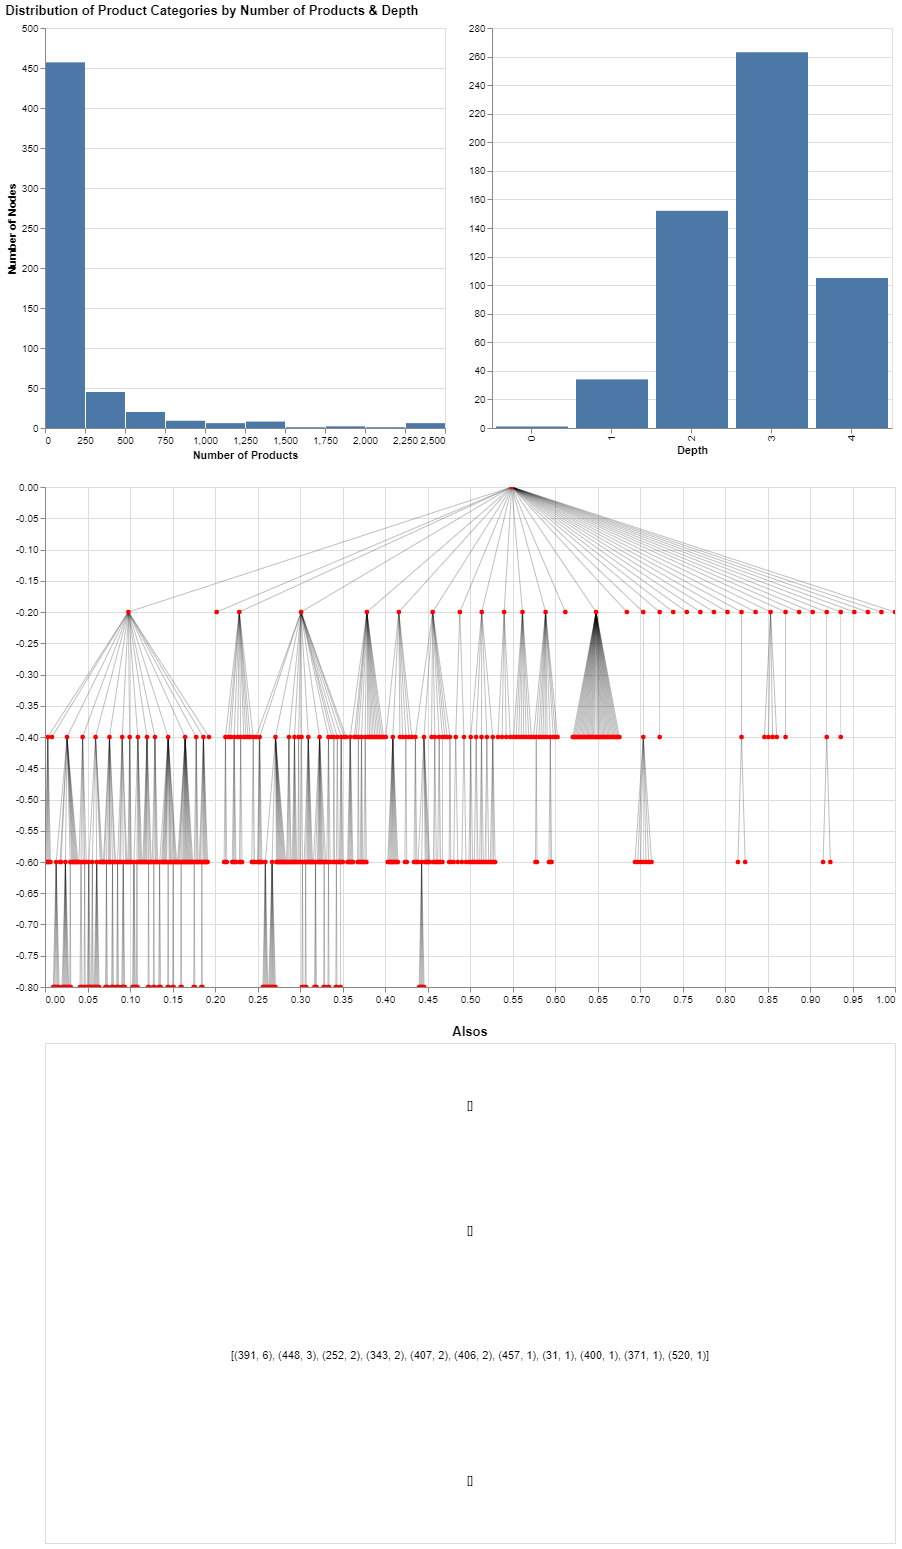

In [213]:
# Get the layers
edges = vg_graph.layer[0]
nodes = vg_graph.layer[1]
attr = vg_graph.layer[2]

#Selection for left chart
brush_left = alt.selection_interval(encodings=['x'],empty='all')
brush_right = alt.selection_multi(encodings=['x'], empty = 'all')
brush_bottom = alt.selection_multi(encodings=['x'], fields=['name','Depth','productCount'], empty='all')

#Product categories by number of products
left = alt.Chart(attr.data).mark_bar().encode(
        alt.X("productCount:Q",
          bin=alt.BinParams(extent = [0,2500], step = 250),
          scale=alt.Scale(domain=(0, 2500)),
          axis=alt.Axis(title="Number of Products")),
        alt.Y('count()',
          axis=alt.Axis(title = "Number of Nodes"))
    ).properties(width = 400, height = 400)

#Product categories by depth
right = alt.Chart(attr.data).mark_bar().encode(
        alt.Y("count()",
             axis=alt.Axis(title = "")),
        alt.X('Depth:O',
              )
    ).properties(width = 400, height = 400)

                 
# gray background with selection
left_background = left.encode(
    color=alt.value('#ddd')
).add_selection(brush_left)

# blue highlights on the transformed data
left_highlight = left.transform_filter(brush_left).transform_filter(brush_right)

left_final = alt.layer(
    left_background,
    left_highlight
    )

right_background = right.encode(
    color=alt.value('#ddd')
).add_selection(brush_right)

# blue highlights on the transformed data
right_highlight = right.transform_filter(brush_left).transform_filter(brush_right)

right_final = alt.layer(
    right_background,
    right_highlight
    )

attr_background = attr.encode(
    opacity=alt.value(0.0)
).add_selection(brush_bottom)

attr_highlight = attr.transform_filter(brush_left).transform_filter(brush_right).transform_filter(brush_bottom)

attr_final = alt.layer(
    attr_background,
    attr_highlight
    )

bottom_final = edges+nodes+attr_final
bottom_final.configure_axis(grid = False)

table = alt.Chart(attr.data).mark_text().encode(
    y=alt.Y('row_number:O',axis=None)
).transform_window(
    row_number='row_number()'
).transform_filter(
    brush_bottom
).encode(text='also:N'
).properties(title = "Alsos"
).transform_window(
    rank='rank(row_number)'
).transform_filter(
    alt.datum.rank<5
).properties(width = 850, height = 500)


alt.vconcat(left_final|right_final,
            bottom_final.properties(width = 850, height = 500)&table,#&table.properties(width = 850, height = 500), 
            data=attr.data, 
            title = "Distribution of Product Categories by Number of Products & Depth",
            resolve = alt.Resolve(scale=alt.LegendResolveMap(color=alt.ResolveMode('independent')), axis=alt.AxisResolveMap('independent'))
           ).display()

altair.vegalite.v3.api.LayerChart

,edge,y,pair,target,x,source
0,0,-0.2,"(0, 1)",1,0.616416,0
1,0,-0.18,"(0, 1)",1,0.899754,0
2,1,-0.2,"(0, 2)",2,1.26884,0
3,1,-0.18,"(0, 2)",2,1.48694,0
4,2,-0.2,"(0, 3)",3,1.43612,0
...,...,...,...,...,...,...
1103,551,-0.78,"(167, 176)",176,2.78724,167
1104,552,-0.8,"(167, 177)",177,2.79491,167
1105,552,-0.78,"(167, 177)",177,2.79381,167
1106,553,-0.8,"(167, 178)",178,2.80221,167


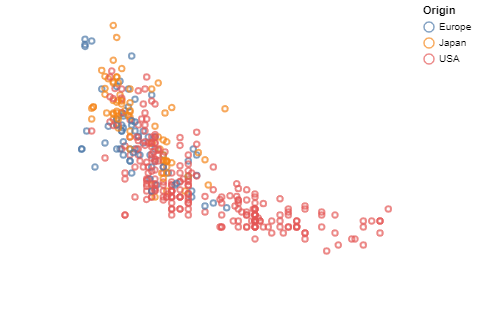

In [183]:
import altair as alt

# load a simple dataset as a pandas DataFrame
from vega_datasets import data
cars = data.cars()

alt.Chart(cars).mark_point().encode(
    alt.X('Horsepower', axis=None),
    alt.Y('Miles_per_Gallon', axis=None),
    color='Origin',
)